# Part 3 Solutions

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from src.styles import FinanceStyles
fs = FinanceStyles()


## 3.1

### Simulation Helpers

In [2]:
from src.solutions.euler_black_scholes import EulerBlackScholes

# Automatically Orchestrate Multiple Runs

def run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, num_simulations):
    """Run multiple simulations with different hedging frequencies."""
    results = {}
    
    for interval in hedge_intervals:
        
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating {interval}-day hedging"):
            # Change up the seec
            np.random.seed(200 + i)
            
            # Run SIM
            model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
            sim_result = model.delta_hedge_short_call(K, interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[interval] = {
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

In [3]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Define hedging intervals to test
hedge_intervals = [1, 5, 21]  # Daily, weekly, and monthly

# Number of simulations
num_simulations = 10000

# Run simulations
results = run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, 
                                    num_simulations)

Simulating 21-day hedging: 100%|██████████| 10000/10000 [00:16<00:00, 607.09it/s]


In [ ]:
# Extract the P&L lists from results dictionary
pnl_1 = np.array(results[1]["all_pnl"])
pnl_5 = np.array(results[5]["all_pnl"])
pnl_21 = np.array(results[21]["all_pnl"])

def perform_f_test(data1, data2):
    # Calculate sample variances (unbiased estimator: ddof=1)
    var1 = np.var(data1, ddof=1)
    var2 = np.var(data2, ddof=1)
    
    # Identify which variance is larger for computing the F statistic
    if var1 >= var2:
        f_stat = var1 / var2
        dfn = len(data1) - 1  # degrees of freedom numerator
        dfd = len(data2) - 1  # degrees of freedom denominator
    else:
        f_stat = var2 / var1
        dfn = len(data2) - 1
        dfd = len(data1) - 1

    # Two-tailed p-value calculation
    p_value = 2 * (1 - stats.f.cdf(f_stat, dfn, dfd))
    
    # p_value should not exceed 1 
    p_value = min(p_value, 1.0)
    return f_stat, dfn, dfd, var1, var2, p_value

# Perform pairwise F-tests
f_1_5, dfn_1_5, dfd_1_5, var1, var5, p_1_5 = perform_f_test(pnl_1, pnl_5)
f_1_21, dfn_1_21, dfd_1_21, var1_again, var21, p_1_21 = perform_f_test(pnl_1, pnl_21)
f_5_21, dfn_5_21, dfd_5_21, var5_again, var21_again, p_5_21 = perform_f_test(pnl_5, pnl_21)

# Create an overview report 
report = f"""
F-Test Results for Variance Comparison of Final P&L Values:

1. **Comparison between results[1]['all_pnl'] and results[5]['all_pnl']:**
   - Variance for key 1: {var1:.4f}
   - Variance for key 5: {var5:.4f}
   - F Statistic: {f_1_5:.4f} (with degrees of freedom {dfn_1_5} and {dfd_1_5})
   - p-value: {p_1_5:.4f}
   => {'Variances differ significantly (reject H0)' if p_1_5 < 0.05 else 'No significant difference in variances (fail to reject H0)'}

2. **Comparison between results[1]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 1: {var1_again:.4f}
   - Variance for key 21: {var21:.4f}
   - F Statistic: {f_1_21:.4f} (with degrees of freedom {dfn_1_21} and {dfd_1_21})
   - p-value: {p_1_21:.4f}
   => {'Variances differ significantly (reject H0)' if p_1_21 < 0.05 else 'No significant difference in variances (fail to reject H0)'}

3. **Comparison between results[5]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 5: {var5_again:.4f}
   - Variance for key 21: {var21_again:.4f}
   - F Statistic: {f_5_21:.4f} (with degrees of freedom {dfn_5_21} and {dfd_5_21})
   - p-value: {p_5_21:.4f}
   => {'Variances differ significantly (reject H0)' if p_5_21 < 0.05 else 'No significant difference in variances (fail to reject H0)'}
"""

print(report)

# Assume pnl_1, pnl_5, and pnl_21 are numpy arrays of your data
sw_stat_1, sw_pvalue_1 = stats.shapiro(pnl_1)
sw_stat_5, sw_pvalue_5 = stats.shapiro(pnl_5)
sw_stat_21, sw_pvalue_21 = stats.shapiro(pnl_21)


print()
print("Shapiro-Wilk Test:")
print(f"Results[1]['all_pnl']: Statistic={sw_stat_1:.4f}, p-value={sw_pvalue_1:.4f}")
print(f"Results[5]['all_pnl']: Statistic={sw_stat_5:.4f}, p-value={sw_pvalue_5:.4f}")
print(f"Results[21]['all_pnl']: Statistic={sw_stat_21:.4f}, p-value={sw_pvalue_21:.4f}")

# Calculate means for each group
mean_1 = np.mean(pnl_1)
mean_5 = np.mean(pnl_5)
mean_21 = np.mean(pnl_21)

# Print the mean values
print()
print("Mean of each group:")
print(f"Results[1]['all_pnl']: {mean_1:.4f}")
print(f"Results[5]['all_pnl']: {mean_5:.4f}")
print(f"Results[21]['all_pnl']: {mean_21:.4f}")

# Perform Welch's t-tests for each pair
t_stat_1_5, p_val_1_5 = stats.ttest_ind(pnl_1, pnl_5, equal_var=False)
t_stat_1_21, p_val_1_21 = stats.ttest_ind(pnl_1, pnl_21, equal_var=False)
t_stat_5_21, p_val_5_21 = stats.ttest_ind(pnl_5, pnl_21, equal_var=False)

# Print the results
print()
print("Results of pairwise t-tests (Welch's t-test):")
print(f"Comparison between results[1]['all_pnl'] and results[5]['all_pnl']: t-statistic = {t_stat_1_5:.4f}, p-value = {p_val_1_5:.4f}")
print(f"Comparison between results[1]['all_pnl'] and results[21]['all_pnl']: t-statistic = {t_stat_1_21:.4f}, p-value = {p_val_1_21:.4f}")
print(f"Comparison between results[5]['all_pnl'] and results[21]['all_pnl']: t-statistic = {t_stat_5_21:.4f}, p-value = {p_val_5_21:.4f}")

# Perform one-sample t-tests for mean = 0
t_1, p_1 = stats.ttest_1samp(pnl_1, 0)
t_5, p_5 = stats.ttest_1samp(pnl_5, 0)
t_21, p_21 = stats.ttest_1samp(pnl_21, 0)

# Print results
print()
print("One-sample t-tests (H0: mean = 0):")
print(f"Results[1]['all_pnl']: t = {t_1:.4f}, p = {p_1:.4f}")
print(f"Results[5]['all_pnl']: t = {t_5:.4f}, p = {p_5:.4f}")
print(f"Results[21]['all_pnl']: t = {t_21:.4f}, p = {p_21:.4f}")



F-Test Results for Variance Comparison of Final P&L Values:

1. **Comparison between results[1]['all_pnl'] and results[5]['all_pnl']:**
   - Variance for key 1: 0.1830
   - Variance for key 5: 0.8575
   - F Statistic: 4.6870 (with degrees of freedom 9999 and 9999)
   - p-value: 0.0000
   => Variances differ significantly (reject H0)

2. **Comparison between results[1]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 1: 0.1830
   - Variance for key 21: 3.6012
   - F Statistic: 19.6830 (with degrees of freedom 9999 and 9999)
   - p-value: 0.0000
   => Variances differ significantly (reject H0)

3. **Comparison between results[5]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 5: 0.8575
   - Variance for key 21: 3.6012
   - F Statistic: 4.1995 (with degrees of freedom 9999 and 9999)
   - p-value: 0.0000
   => Variances differ significantly (reject H0)


Shapiro-Wilk Test:
Results[1]['all_pnl']: Statistic=0.9814, p-value=0.0000
Results[5]['all_pnl']: Statistic

### Visualisations

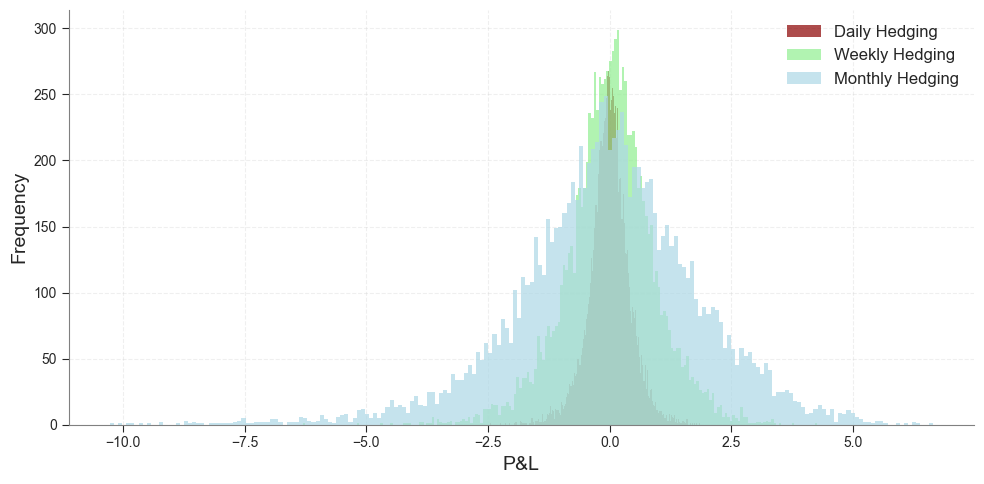

In [ ]:
# 1. P&L Distribution Comparison
plt.figure(figsize=(10, 5))
colors = ['darkred', 'lightgreen', 'lightblue']
for i, interval in enumerate(hedge_intervals):
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
        
    plt.hist(results[interval]['all_pnl'], bins=200, alpha=0.7, 
             color=colors[i], label=f"{interval_desc} Hedging")

# Apply styling
fs.plot_distribution(
                    xlabel='P&L', ylabel='Frequency')

fs.finalize_plot(filename="src/figures/p3/pl_distr_by_hedge_freq")
plt.legend()
plt.show()

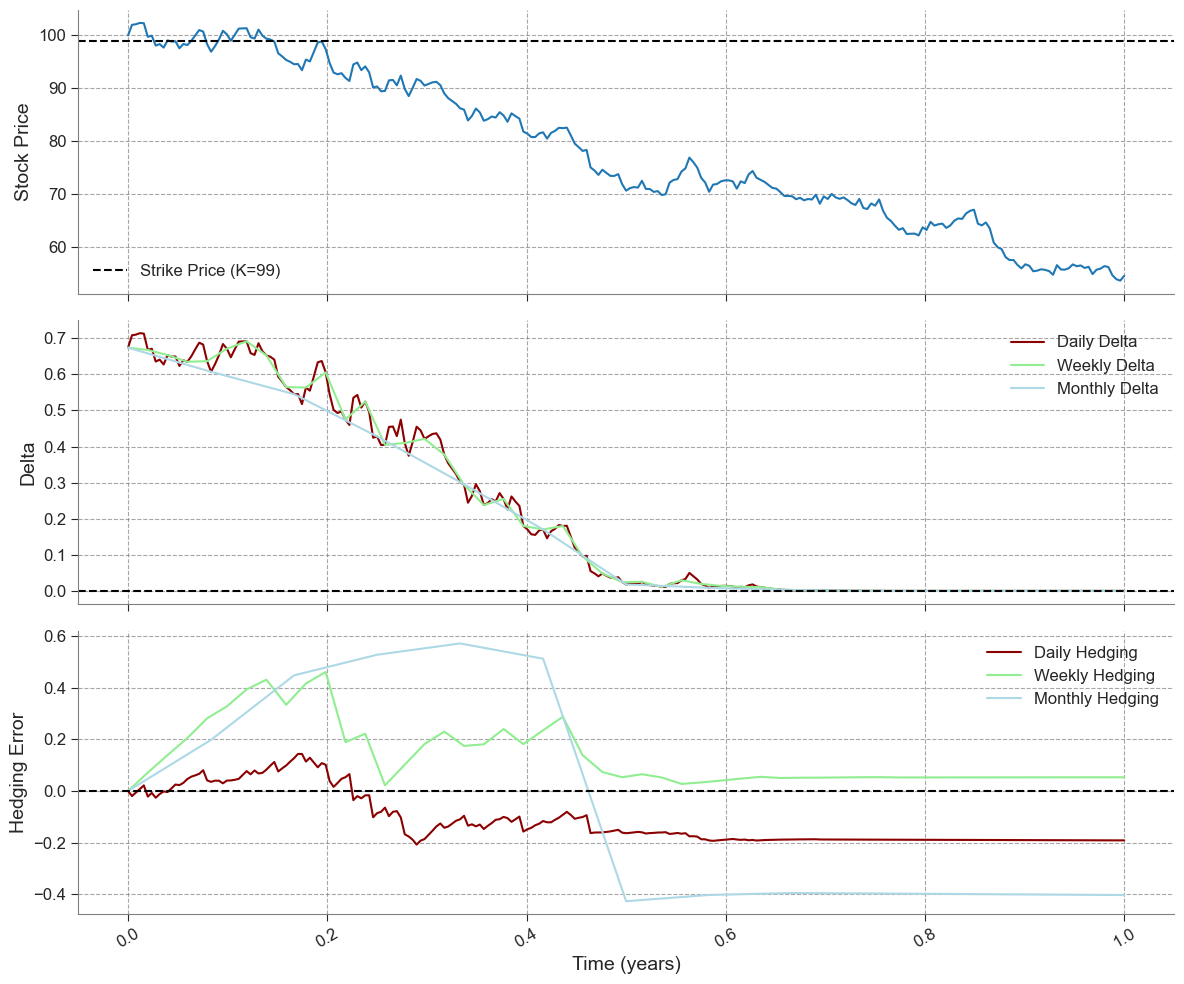

In [ ]:
# 2. Single Simulation Analysis with Different Frequencies
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

seed = 14
# Use same seed for all simulations to compare hedging frequency effect on same path
np.random.seed(seed)
# Simulate stock path once
model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
time, stock_path = model.simulate()

# Stock path plot
ax1.plot(time, stock_path)
ax1.axhline(y=K, color='black', linestyle='--', label=f'Strike Price (K={K})')
fs.plot_timeseries(ax=ax1, ylabel='Stock Price')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
ax1.legend()

# Colors for each frequency
colors = ['darkred', 'lightgreen', 'lightblue']

# Loop over frequencies 
for i, interval in enumerate(hedge_intervals):
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
    
    # Re‑seed so each freq uses the same stock path
    np.random.seed(seed)
    model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
    sim = model.delta_hedge_short_call(K, interval)
    
    # Delta plot
    ax2.plot(sim['hedge_times'], sim['delta_values'],
             label=f"{interval_desc} Delta",
             color=colors[i])
    
    # Hedging error plot
    min_length = min(len(sim['portfolio_values']), len(sim['option_values']))
    hedging_error = sim['portfolio_values'][:min_length] \
                  - sim['option_values'][:min_length]
    ax3.plot(sim['hedge_times'][:min_length], hedging_error,
             label=f"{interval_desc} Hedging",
             color=colors[i])

# Delta plot
fs.plot_timeseries(ax=ax2, ylabel='Delta')
ax2.legend(loc='upper right')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# Hedging error plot
fs.plot_timeseries(ax=ax3, xlabel='Time (years)', ylabel='Hedging Error')
ax3.axhline(y=0, color='black', linestyle='--')
ax3.legend(loc='upper right')
ax3.grid(True, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

fs.finalize_plot(fig=fig, filename="src/figures/p3/stock_price_path")
plt.show()
plt.close()



In [ ]:
# Set parameters
num_simulations = 10000
hedge_intervals = [1, 5, 21]
hedge_labels = {1: "Daily", 5: "Weekly", 21: "Monthly"}

# Initialize storage for results
hedging_errors = {interval: [] for interval in hedge_intervals}
hedge_times_dict = {interval: None for interval in hedge_intervals}

# Run simulations
for sim_num in range(num_simulations):
    np.random.seed(200 + sim_num) 

    # Generate stock path once per simulation
    model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
    time, stock_path = model.simulate()

    for interval in hedge_intervals:
        # Use the same stock path, not a new model for each interval
        sim = model.delta_hedge_short_call(K, interval)

        # Align lengths for hedging error computation
        min_length = min(len(sim['portfolio_values']), len(sim['option_values']))
        error = np.array(sim['portfolio_values'][:min_length]) - np.array(sim['option_values'][:min_length])
        hedging_errors[interval].append(error)

        # Save hedge times once per interval
        if (hedge_times_dict[interval] is None or 
            len(hedge_times_dict[interval]) < len(sim['hedge_times'][:min_length])):
            hedge_times_dict[interval] = sim['hedge_times'][:min_length]




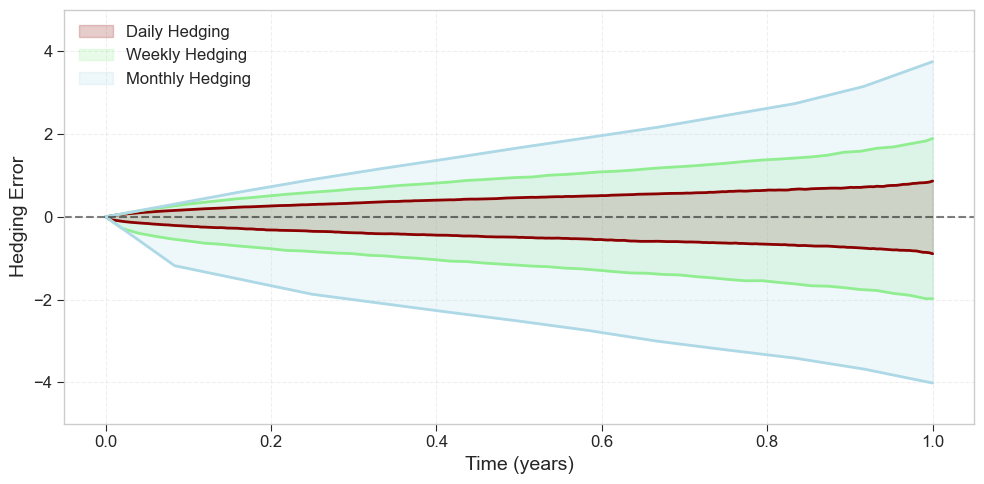

In [ ]:
# Plotting mean + 95% prediction interval of hedging error per interval
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['darkred', 'lightgreen', 'lightblue']

for i, interval in enumerate(hedge_intervals):
    errors = np.vstack(hedging_errors[interval])   
    times  = np.array(hedge_times_dict[interval])

    mean_error = errors.mean(axis=0)
    # 95% prediction bounds
    lower_pi = np.percentile(errors,  2.5, axis=0)
    upper_pi = np.percentile(errors, 100-2.5, axis=0)

    # fill prediction band
    ax.fill_between(times, lower_pi, upper_pi, color=colors[i], alpha=0.2, label=f"{hedge_labels[interval]} Hedging")
    ax.plot(times, upper_pi, color=colors[i], linewidth=2)
    ax.plot(times, lower_pi, color=colors[i], linewidth=2)


# finalize
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Hedging Error")
ax.set_ylim(-5, 5)   
ax.legend()
plt.tight_layout()
plt.show()



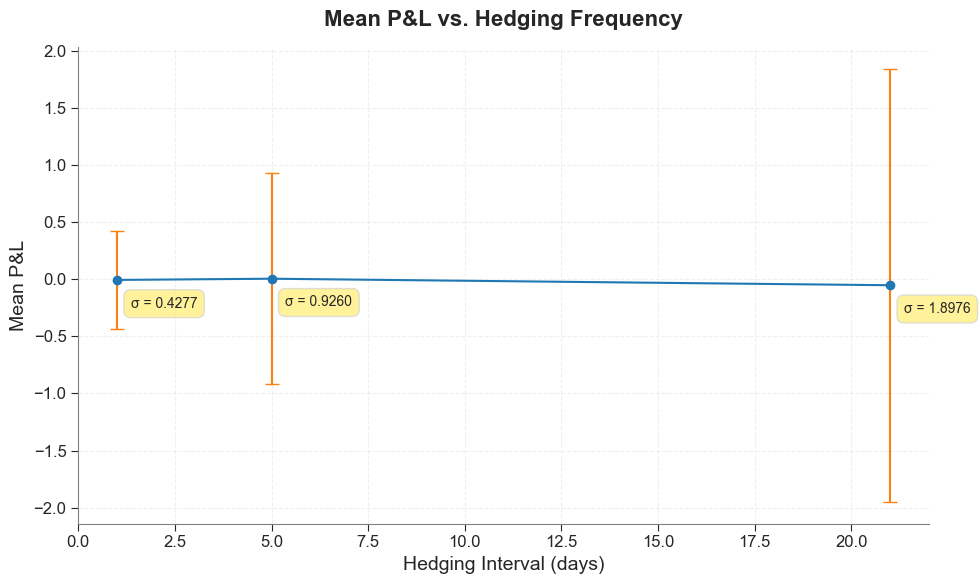

In [ ]:
# 3. Scatter plot of P&L vs. Hedging Frequency [Not used for report]
plt.figure(figsize=(10, 6))
mean_pnls = [results[interval]['mean_pnl'] for interval in hedge_intervals]
std_pnls = [results[interval]['std_pnl'] for interval in hedge_intervals]
plt.errorbar(hedge_intervals, mean_pnls, yerr=std_pnls, fmt='o-', capsize=5, 
            color=fs.colors['neutral'], ecolor=fs.colors['highlight'])
# plt.xscale('log')

# Add annotations with standard deviations
for i, interval in enumerate(hedge_intervals):
    fs.annotate_point(plt.gca(), interval, mean_pnls[i], 
                     f'σ = {std_pnls[i]:.4f}', 
                     fc='#ffed6f', alpha=0.7)

# Apply styling and finalize
fs.style_errorbar(title='Mean P&L vs. Hedging Frequency', 
                 xlabel='Hedging Interval (days)', ylabel='Mean P&L')
fs.finalize_plot(filename="src/figures/p3/mean_pl_vs_hedge_freq")
plt.show()


## 3.2

### Simulation Helpers 

In [7]:
def get_key(vol_true, vol_model):
    return f"true/model [{vol_true:.2f}/{vol_model:.2f}]"

def run_volatility_mismatch_simulations(S0, K, r, T, N, hedge_interval, 
                                        vol_true_list, vol_model_list, num_simulations):
    """
    Run simulations with different combinations of true and model volatilities.
    
    Parameters:
    S0, K, r, T, N : Standard Black-Scholes parameters
    hedge_interval : Frequency of hedging adjustments
    vol_true_list : List of true volatilities for simulation
    vol_model_list : List of model volatilities for pricing/hedging
    num_simulations : Number of simulations for each volatility combination
    
    Returns:
    dict: Results organized by volatility combinations
    """
    results = {}
    
    # Create a meshgrid of all volatility combinations
    from itertools import product
    vol_combinations = list(product(vol_true_list, vol_model_list))
    
    for vol_true, vol_model in vol_combinations:
        key = get_key(vol_true,vol_model)
        
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating for {key}"):
            # Set a different seed for each simulation
            np.random.seed(i)
            
            # Create model and run simulation
            model = EulerBlackScholes(S0, r, vol_true, vol_model, T, N)
            sim_result = model.delta_hedge_short_call(K, hedge_interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[key] = {
            'true_vol': vol_true,
            'model_vol': vol_model,
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

def analyze_single_path(S0, K, r, T, N, hedge_interval, vol_true, vol_model_list):
    """Analyze a single price path with different model volatilities."""
    results = {}
    
    # Generate one price path with the true volatility
    np.random.seed(42)  # For reproducibility
    base_model = EulerBlackScholes(S0, r, vol_true, vol_true, T, N)
    time, S = base_model.simulate()
    
    # Use this same path with different model volatilities
    for vol_model in vol_model_list:
        model = EulerBlackScholes(S0, r, vol_true, vol_model, T, N)
        
        # Override the simulate method to use our pre-generated path
        original_simulate = model.simulate
        model.simulate = lambda: (time, S)
        
        # Run the hedging simulation
        sim_result = model.delta_hedge_short_call(K, hedge_interval)
        
        # Store results
        key = get_key(vol_true,vol_model)
        results[key] = {
            'true_vol': vol_true,
            'model_vol': vol_model,
            'final_pnl': sim_result['final_pnl'],
            'portfolio_values': sim_result['portfolio_values'],
            'option_values': sim_result['option_values'],
            'delta_values': sim_result['delta_values'],
            'hedge_times': sim_result['hedge_times']
        }
        
        # Restore original method
        model.simulate = original_simulate
    
    return time, S, results

In [8]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Hedging frequency
hedge_interval = 5  # Weekly hedging

# Volatility lists to test
vol_true_list = [0.10, 0.20, 0.30]  # True volatilities
vol_model_list = [0.10, 0.20, 0.30]  # Model volatilities

# Number of simulations
num_simulations = 100

# 1. Run simulations with different volatility combinations
results = run_volatility_mismatch_simulations(S0, K, r, T, N, hedge_interval, 
                                            vol_true_list, vol_model_list, num_simulations)

Simulating for true/model [0.30/0.30]: 100%|██████████| 100/100 [00:02<00:00, 36.21it/s]


### Visualisations

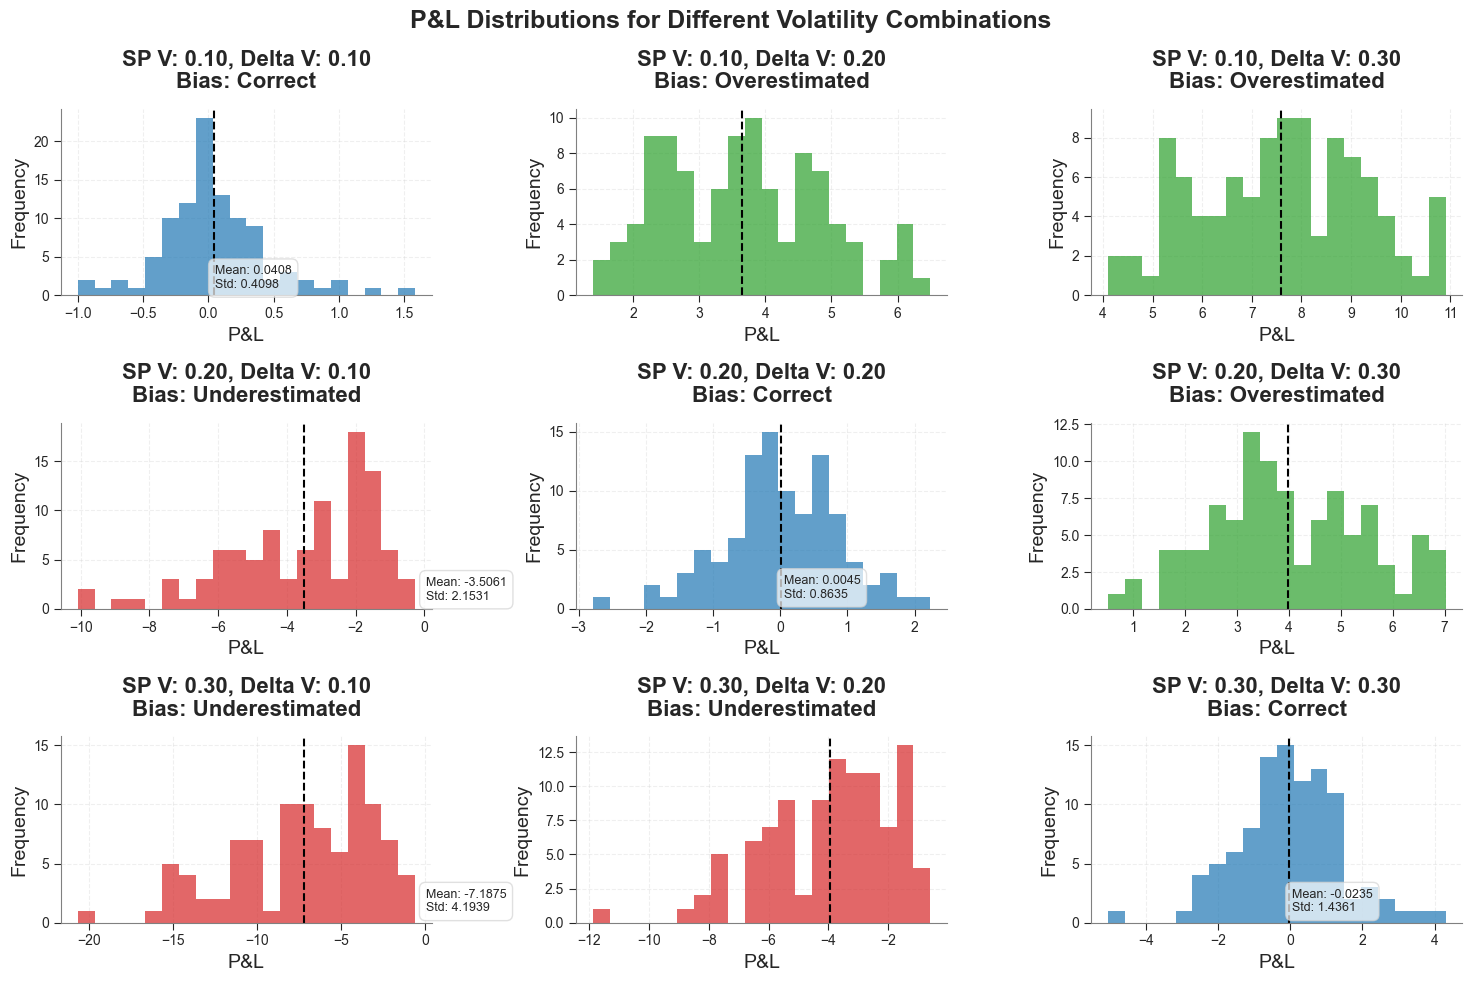

In [9]:
# 4. Visualize P&L distributions for different volatility combinations
fig = plt.figure(figsize=(15, 10))
# Create a grid for subplots - one row for each true volatility
num_true_vols = len(vol_true_list)
num_model_vols = len(vol_model_list)

for i, vol_true in enumerate(vol_true_list):
    for j, vol_model in enumerate(vol_model_list):
        key = get_key(vol_true, vol_model)
        
        # Create subplot
        ax = plt.subplot(num_true_vols, num_model_vols, i*num_model_vols + j + 1)
        
        # Calculate hedging bias
        bias = vol_model - vol_true
        
        # Choose color based on bias
        if bias == 0:
            color = fs.colors['neutral']
        elif bias < 0:
            color = fs.colors['negative']
        else:
            color = fs.colors['positive']
            
        bias_text = "Overestimated" if bias > 0 else "Underestimated" if bias < 0 else "Correct"
        
        # Plot histogram of P&L
        plt.hist(results[key]['all_pnl'], bins=20, alpha=0.7, color=color)
        plt.axvline(results[key]['mean_pnl'], color='k', linestyle='--')
        
        # Apply styling to subplot
        fs.plot_distribution(ax=ax, 
                            title=f"SP V: {vol_true:.2f}, Delta V: {vol_model:.2f}\nBias: {bias_text}",
                            xlabel='P&L', ylabel='Frequency', legend=False)
        
        # Add mean and std as text
        fs.annotate_point(ax, 0.05, 0.95, 
                         f"Mean: {results[key]['mean_pnl']:.4f}\nStd: {results[key]['std_pnl']:.4f}", 
                         xytext=(0, 0), fontsize=9)

# Finalize the figure
fs.finalize_plot(fig=fig, suptitle='P&L Distributions for Different Volatility Combinations',
                filename="src/figures/p3/pl_for_diff_volatility_combos")
plt.show()

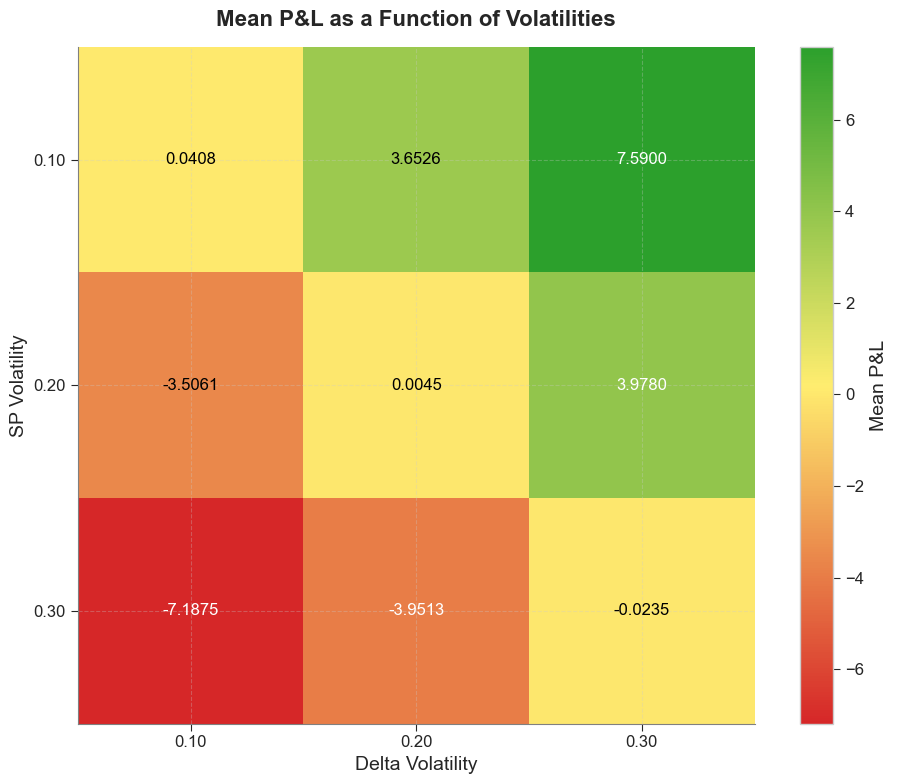

In [10]:
# 5. Heat map of mean P&L
plt.figure(figsize=(10, 8))
# Prepare data for heatmap
heatmap_data = np.zeros((len(vol_true_list), len(vol_model_list)))
for i, vol_true in enumerate(vol_true_list):
    for j, vol_model in enumerate(vol_model_list):
        key = get_key(vol_true, vol_model)
        heatmap_data[i, j] = results[key]['mean_pnl']

# Create heatmap
ax = plt.gca()
im = plt.imshow(heatmap_data, cmap=fs.cmap_ryg, interpolation='nearest')
plt.colorbar(im, label='Mean P&L')

# Set labels
plt.xticks(np.arange(len(vol_model_list)), [f"{v:.2f}" for v in vol_model_list])
plt.yticks(np.arange(len(vol_true_list)), [f"{v:.2f}" for v in vol_true_list])

# Apply styling
fs.plot_heatmap(title='Mean P&L as a Function of Volatilities',
               xlabel='Delta Volatility', ylabel='SP Volatility')

# Add text annotations
for i in range(len(vol_true_list)):
    for j in range(len(vol_model_list)):
        value = heatmap_data[i, j]
        text_color = 'white' if abs(value) > np.max(np.abs(heatmap_data))/2 else 'black'
        ax.text(j, i, f"{value:.4f}", ha="center", va="center", color=text_color)

# Finalize
fs.finalize_plot(filename="src/figures/p3/mean_pl_volatilities")
plt.show()

##